           Gare Heure d'arrivée Heure de départ  Places disponibles
0   FRANCEVILLE            None           15:00                  79
1        MOANDA           15:41           16:01                  79
2  LASTOURVILLE           18:26           18:46                  79
3        IVINDO           21:07           21:09                  79
4         BOOUE           21:55           22:15                  79
5          LOPE           23:29           23:39                  79
6        NDJOLE           02:16           02:31                  79
7  OWENDO VIRIE           07:53            None                  79
                Gare Heure d'arrivée Heure de départ  Places disponibles
0       OWENDO VIRIE            None           15:00                 142
1              NTOUM           16:10           16:15                 142
2              ANDEM           16:50           16:52                 142
3               MBEL           17:46           17:48                 142
4               OYAN   

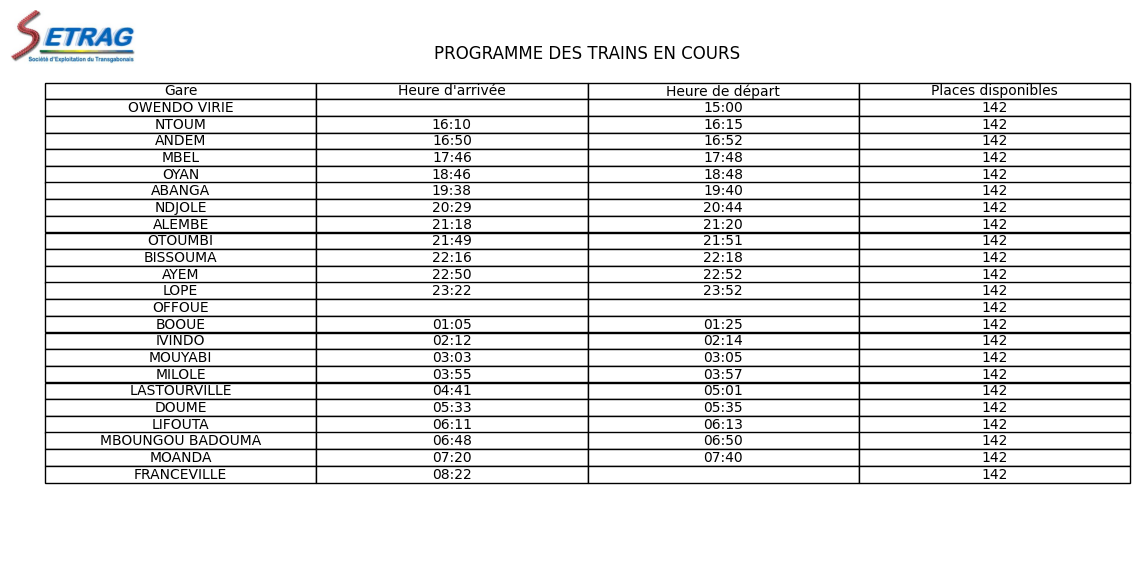

In [6]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sshtunnel import SSHTunnelForwarder

# Define your SSH and MySQL credentials
ssh_host = '10.120.21.103'
ssh_port = 22
ssh_user = 'setrag'
ssh_password = 'Wabjtam,123'

mysql_host = '192.168.21.110'
mysql_port = 3306
mysql_user = 'galera'
mysql_password = 'galera'
mysql_db = 'setrag_beta1'

# Charger l'image
image_path = 'setraglogo.jpg'
img = mpimg.imread(image_path)

# Establish the SSH tunnel
with SSHTunnelForwarder(
    (ssh_host, ssh_port),
    ssh_username=ssh_user,
    ssh_password=ssh_password,
    remote_bind_address=(mysql_host, mysql_port)
) as tunnel:
    # Connect to the MySQL database
    connection = pymysql.connect(
        host='127.0.0.1',
        user=mysql_user,
        password=mysql_password,
        db=mysql_db,
        port=tunnel.local_bind_port
    )

    # Execute a query
    with connection.cursor() as cursor:
        #Recovery of available seats on all trains for the current month
        cursor.execute("""
                            SELECT t.number AS "N° TRAIN",
                            	   tp.label AS "TYPE DE TRAIN",
                                   DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "DATE DE DEPART",
                                   DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%H:%i") AS "HEURE DE DEPART",
                                   IF(wdr.departure_station = 1, "OWENDO VIRIE", "FRANCEVILLE") AS "GARE DE DEPART",
                                   IF(wdr.arrival_station = 23, "FRANCEVILLE", "OWENDO VIRIE") AS "GARE D'ARRIVEE",
                            	   count(sbr.seat_occupation_flag) AS "PLACES DISPONIBLES"
                            FROM train AS t
                            INNER JOIN seat_booking_record AS sbr
                            ON sbr.train_id = t.id
                            INNER JOIN seat AS s
                            ON s.id = sbr.seat_id
                            INNER JOIN car AS c
                            ON c.id = s.car_id
                            INNER JOIN train_type tp
                            ON t.train_type_id = tp.id
                            INNER JOIN week_day_route  wdr
                            ON wdr.id = t.week_day_route_id
                            WHERE
                            (t.planned_date/1000) BETWEEN UNIX_TIMESTAMP(DATE_FORMAT(CURDATE(), '%Y-%m-01 00:00:00')) AND UNIX_TIMESTAMP(DATE_FORMAT(LAST_DAY(CURDATE()), '%Y-%m-%d 23:59:59'))
                            AND sbr.seat_occupation_flag = 0 AND tp.label IN ('EXPRESS', 'OMNIBUS')
                            GROUP BY DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y"), t.number
                        """)
        trains_places_dispo = cursor.fetchall()
        field_names = [i[0] for i in cursor.description]
        """print(field_names)
        for result in trains_places_dispo:
            print(result)"""

        # Requête d'itineraire des trains en cours
        query_itineraire_train = """
                                        SELECT 
                                    		wdr.train_number,
                                            ts.name,
                                            tt.label,
                                            DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "DATE DE DEPART",
                                    		DATE_FORMAT(FROM_UNIXTIME(rs.arrival_time/1000), "%H:%i") AS "HEURE D'ARRIVEE",
                                    		DATE_FORMAT(FROM_UNIXTIME(rs.departure_time/1000), "%H:%i") AS "HEURE DE DEPART",
                                            DATE_FORMAT(FROM_UNIXTIME(rs.stop_duration/1000), "%H:%i") AS "HEURE DE D'ARRET"
                                        FROM route_station rs
                                        INNER JOIN train_station ts
                                        ON ts.id = rs.train_station_id
                                        INNER JOIN week_day_route wdr
                                        ON wdr.id = rs.week_day_route_id
                                        INNER JOIN train_type tt
                                        ON tt.id = wdr.train_type_id
                                        INNER JOIN train t
                                        ON t.week_day_route_id = wdr.id
                                        WHERE
                                        #(t.planned_date/1000) BETWEEN UNIX_TIMESTAMP(NOW()) AND UNIX_TIMESTAMP(DATE_ADD(NOW(), INTERVAL 1 DAY))
                                        (t.planned_date/1000) BETWEEN UNIX_TIMESTAMP('2024-12-15 00:00:00') AND UNIX_TIMESTAMP('2024-12-15 23:59:59')
                                        AND tt.label IN ('EXPRESS', 'OMNIBUS')
                                """
        cursor.execute(query_itineraire_train)
        trains_itineraire_details = cursor.fetchall()
    
        data_express = []
        data_omnibus = []
        
        for details in trains_itineraire_details:
            for train in trains_places_dispo:
                if train[0] == details[0] and details[3] == train[2] and details[2] == "EXPRESS":
                    #print(details[1]," ",details[4], " ", details[5], " ",train[6])
                    donnees = (details[1], details[4],details[5],train[6])
                    data_express.append(donnees)
                if train[0] == details[0] and details[3] == train[2] and details[2] == "OMNIBUS":
                    donnees = (details[1], details[4],details[5],train[6])
                    data_omnibus.append(donnees)
                    
        df_express = pd.DataFrame(data_express, columns=["Gare", "Heure d'arrivée", "Heure de départ", "Places disponibles"])
        df_omnibus = pd.DataFrame(data_omnibus, columns=["Gare", "Heure d'arrivée", "Heure de départ", "Places disponibles"])
        print(df_express)
        print(df_omnibus)
        # Plot the DataFrame as a table
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.axis('tight')
        ax.axis('off')

        ax.set_title("PROGRAMME DES TRAINS EN COURS", y=0.9)
        #table = ax.table(cellText=df_express.values, colLabels=df_express.columns, cellLoc='center', loc='center')
        ax.table(cellText=df_omnibus.values, colLabels=df_omnibus.columns, cellLoc='center', loc='center')

        # Ajouter un nouvel axe pour le logo
        logo_ax = fig.add_axes([0.1, 0.8, 0.09, 0.085], anchor='NE', zorder=-1)
        logo_ax.imshow(img)
        logo_ax.axis('off')  # Masquer les axes du logo
        
        # Save the table as a JPEG image
        plt.savefig('omnibus.jpg', format='jpeg')
    # Close the connection
    connection.close()